# Importing packages

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller

In [24]:
pd.plotting.register_matplotlib_converters()

In [8]:
mat.rcParams.update({'figure.figsize':(20,15), 'font.size': 14})

# Reading the data

In [49]:
energy_consumption = pd.read_csv('energy consumption per day.csv')

In [50]:
energy_consumption.dtypes

Datetime     object
PJME_MW     float64
dtype: object

In [51]:
energy_consumption['Datetime'] = pd.to_datetime(energy_consumption['Datetime'])

In [52]:
energy_consumption.index = pd.DatetimeIndex(energy_consumption['Datetime'],freq='D')

In [53]:
energy_consumption.drop(['Datetime'],1,inplace=True)

# Stationarity Test

In [54]:
result = adfuller(energy_consumption['PJME_MW'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    if result[0] <= value:
        print('Stationary at ' + key)
    else:
        print('Non-Stationary at ' + key)

ADF Statistic: -8.276309
p-value: 0.000000
Critical Values:
	1%: -3.431
Stationary at 1%
	5%: -2.862
Stationary at 5%
	10%: -2.567
Stationary at 10%


In [55]:
energy_consumption['ds'] = energy_consumption.index
energy_consumption.rename(columns={'PJME_MW':'y'},inplace=True)

# Train Test Data

In [56]:
split_date = '06-30-2018'
train = energy_consumption.loc[:split_date].copy()
test = energy_consumption.loc[split_date:].copy()

# Time Series Prediction

In [57]:
m = Prophet()

In [58]:
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [59]:
future = m.make_future_dataframe(periods=len(test))

In [60]:
forecast = m.predict(future)

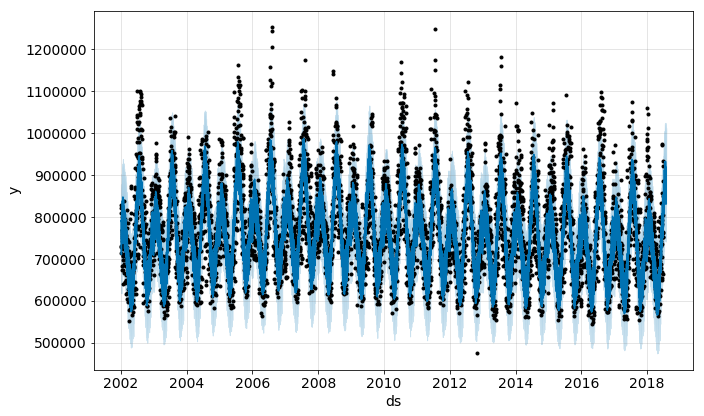

In [61]:
m.plot(forecast)
plt.show()

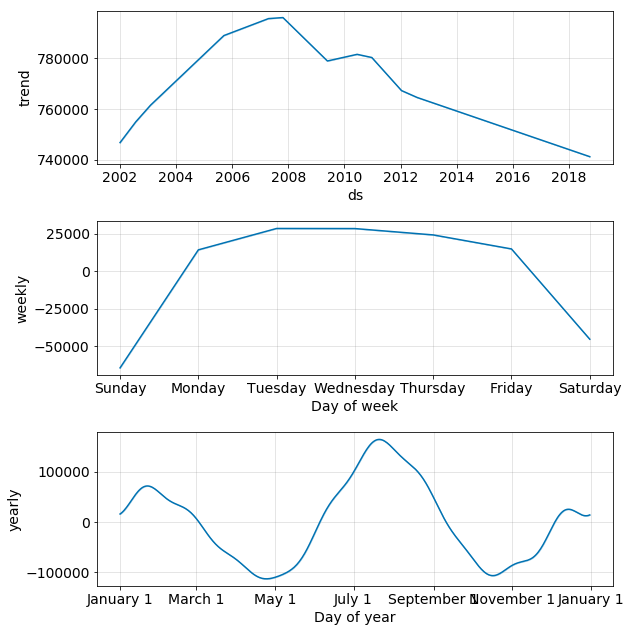

In [38]:
m.plot_components(forecast)
plt.show()

In [43]:
prediction_vs_real = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(energy_consumption.set_index('ds'))

In [46]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [47]:
calculate_forecast_errors(prediction_vs_real, len(test))

{'MAPE': 8.786580159069493, 'MAE': 76769.94448267638}